<a href="https://colab.research.google.com/github/EilieYoun/Narnia-Edu/blob/main/Lecture/240822_kaist/02_DeepSDF_%ED%95%B4%EC%84%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024 KAIST 생성AI 실습 :  DeepSDF

* 날짜:
* 이름:



## **(0) Environment Setup**
---

### **| Utils**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def draw_grid(grid, mn=-4, mx=4):
    plt.figure(figsize=(8,8))
    plt.imshow(grid, cmap='RdBu', vmin=mn, vmax=mx, extent=[mn, mx, mn, mx])
    plt.colorbar( shrink=0.8)
    plt.show()

def compare_grid(net, circle, points, mn=-5, mx=5, resolution=200):
    net.eval()
    with torch.no_grad():
        sdf_pred = net(points)
    sdf_pred = sdf_pred.detach().cpu().numpy()[:,0]
    sdf_grid_pred = np.reshape(sdf_pred, (resolution, resolution))

    sdf_grid_real = [circle.sdf(px, py) for px, py in zip(points[:,0], points[:,1])]
    sdf_grid_real = np.reshape(sdf_grid_real, (resolution, resolution))

    plt.figure(figsize=(13,6))

    ax1 = plt.subplot(121)
    ax1.set_title('Network SDF')
    vmin = min(sdf_grid_pred.min(), -sdf_grid_pred.max())
    vmax = max(sdf_grid_pred.max(), -sdf_grid_pred.min())
    img1 = ax1.imshow(sdf_grid_pred, cmap='RdBu', vmin=vmin, vmax=vmax, extent=[mn, mx, mn, mx])
    plt.colorbar(img1, ax=ax1, shrink=0.8)

    ax2 = plt.subplot(122)
    ax2.set_title('Original SDF')
    vmin = min(sdf_grid_real.min(), -sdf_grid_real.max())
    vmax = max(sdf_grid_real.max(), -sdf_grid_real.min())
    img2 = ax2.imshow(sdf_grid_real, cmap='RdBu', vmin=vmin, vmax=vmax, extent=[mn, mx, mn, mx])
    plt.colorbar(img2, ax=ax2, shrink=0.8)


## **(1) What is SDF?**

**Signed Distance Function (SDF)**는 3D 그래픽스 및 컴퓨터 비전에서 자주 사용되는 개념으로, 주어진 공간의 각 점에서 가장 가까운 표면까지의 거리와 그 방향을 나타냅니다. SDF는 다음과 같은 특성을 가지고 있습니다:

- 거리 계산: SDF는 공간 내의 임의의 점에서 표면까지의 최단 거리를 계산합니다.
- 부호: SDF의 값은 부호를 가집니다. 표면 내부의 점은 음의 값을 가지며, 표면 외부의 점은 양의 값을 가집니다. 표면 자체의 점은 0의 값을 가집니다.
- 표면 표현: SDF는 임의의 3D 형상을 수학적으로 간결하게 표현할 수 있으며, 복잡한 형상도 간단하게 다룰 수 있습니다.

이러한 특성 때문에 SDF는 충돌 감지, 형태 최적화, 3D 모델링 및 렌더링 등 다양한 응용 분야에서 활용됩니다. 예를 들어, 3D 모델의 표면을 정의하고 그 표면과의 거리를 계산하여 물리적 충돌을 감지할 수 있습니다.

이번 시간에는 SDF의 개념을 이해하기 위해 원을 예제로 사용해 보겠습니다. 원은 2D 공간에서 간단한 형상으로, 각 점에서 원의 경계까지의 거리를 계산하여 SDF를 쉽게 설명할 수 있습니다. 다음 섹션에서는 원의 SDF를 정의하고, 다양한 점들에 대해 SDF 값을 계산하여 시각화하는 과정을 다루겠습니다. 이를 통해 SDF가 어떻게 작동하는지에 대한 직관적인 이해를 돕고자 합니다.









### **| Define Circle**

여기서는 `Circle` 클래스를 정의합니다. 이 클래스는 중심 좌표 `(cx, cy)`와 반지름 `(r)`을 가지며, `sdf` 메서드는 주어진 점 `(px, py)`에 대한 **Signed Distance Function** 값을 계산합니다. 이 함수는 점과 원의 경계 사이의 거리를 나타냅니다.



In [ ]:
class Circle():
    def __init__(self, cx, cy, r):
        self.cx = cx
        self.cy = cy
        self.r = r

    def sdf(self, px, py):
        point = np.float_([px, py])
        center = np.float_([self.cx, self.cy])
        sdf = np.linalg.norm(point - center) - self.r
        return sdf

중심 좌표가 `(0, 0)` 이고 반지름이 2 인 원을 정의합니다.

In [ ]:
circle = Circle(0, 0, 2)

### **| Get points**

이 함수는 지정된 범위 `(mn~mx)` 와 해상도 `(resolution)` 에 따라 2D 평면의 격자점들을 생성합니다. 각 점의 좌표는 리스트로 저장되고, 이 리스트는 나중에 Numpy 배열로 변환됩니다. 이 배열은 후속 SDF 계산에 사용됩니다.

In [ ]:
def get_points(mn=-5, mx=5, resolution=200):
    points = []
    for px in np.linspace(mn, mx, resolution):
        for py in np.linspace(mn, mx, resolution):
            points.append([px, py])
    points = np.array(points, dtype=np.float32)
    return points

범위 (-5~5) 이며 해상도 200 인 격자점들을 생성합니다.

In [ ]:
points = get_points(-5, 5, 200)
print(points.shape)

(40000, 2)


### **| Get SDF Values**

앞에서 얻은 격자점에 대하여 `Circle` 클래스의 `sdf` 메서드를 호출하여 SDF 값을 계산합니다.

In [ ]:
sdf_values = np.array([circle.sdf(px, py) for px, py in zip(points[:,0], points[:,1])] )
print(sdf_values.shape)

(40000,)


### **| Visualize**

계산된 SDF 값들을 2D 그리드 형태로 재배열하여 시각화합니다. `draw_grid` 함수를 사용하여 그리드를 시각화할 수 있습니다.

(200, 200)


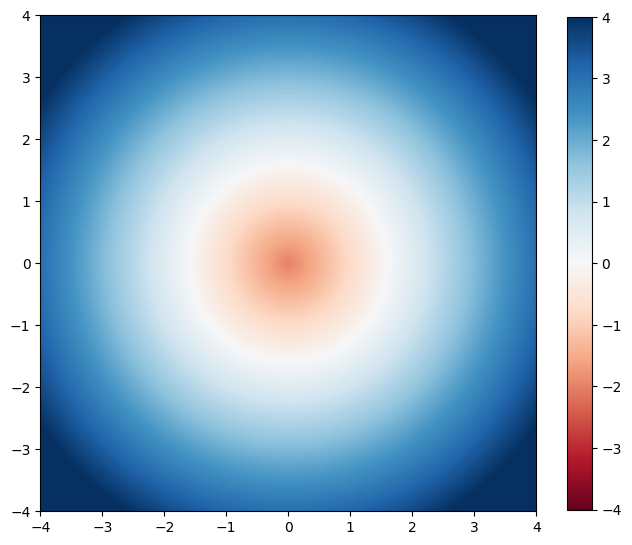

In [ ]:
sdf_grid = np.reshape(sdf_values, (200, 200))
print(sdf_grid.shape)
draw_grid(sdf_grid)

SDF 값이 양수인 영역을 1로, 음수인 영역을 0으로 설정하여 `voxel grid`를 생성할 수 있습니다. SDF와 voxel을 차이를 시각적으로 비교해 봅니다.

(200, 200)


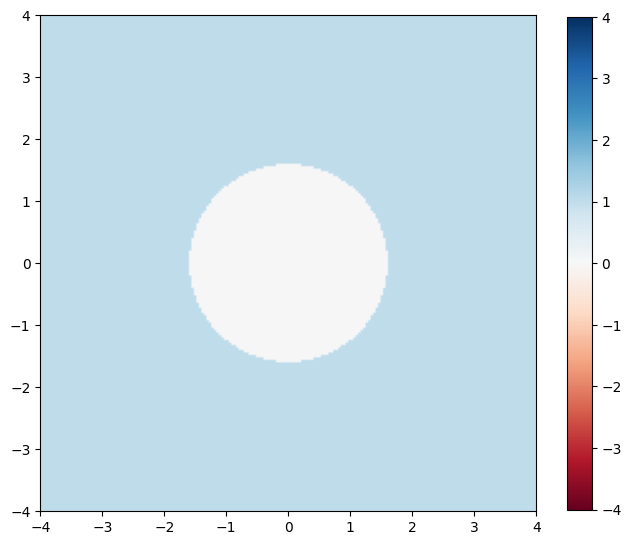

In [ ]:
voxel_grid = np.where(sdf_grid>0, 1., 0.)
print(voxel_grid.shape)
draw_grid(voxel_grid)

## **(2) Dataset**

이 섹션에서는 **Signed Distance Function (SDF)**를 기반으로 학습 데이터를 생성하고 준비하는 과정을 설명합니다. 여기서는 원(Circle)을 이용하여 SDF 값을 계산하고, 이를 통해 학습과 테스트를 위한 데이터셋을 생성합니다.

$$ TRAIN := \{((x, y), s) : SDF(x, y) = s\} $$

### **| Generate Data Points**

`get_points` 함수를 사용하여 학습(train) 및 테스트(test) 데이터 포인트를 생성합니다.

- `train_points` : (-3, 3) 범위에서 40x40 격자 포인트를 생성
- `test_points` : (-5, 5) 범위에서 200x200 격자 포인트를 생성



In [ ]:
train_points = get_points(-3, 3, 40)
test_points = get_points(-5, 5, 200)
train_points.shape, test_points.shape

((1600, 2), (40000, 2))

전체 `sdf_grid`를 먼저 시각하고, 그 위에 `train_points`와 `test_points`를 오버레이합니다. 이를 통해 데이터의 분포를 시각적으로 확인할 수 있습니다.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


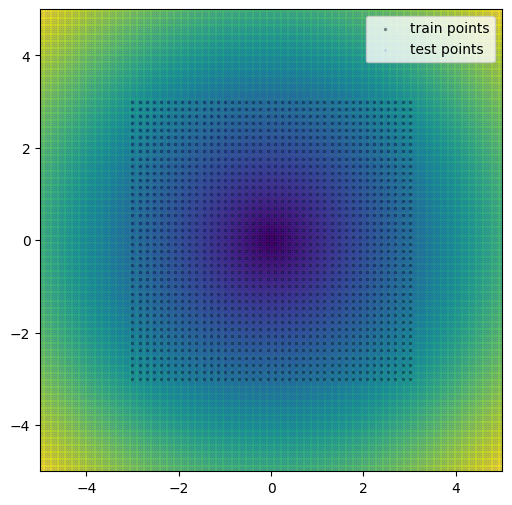

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(sdf_grid, extent=[-5, 5, -5, 5])
plt.scatter(train_points[:,0], train_points[:,1], edgecolor="k", alpha=.4, s=2, label='train points')
plt.scatter(test_points[:,0], test_points[:,1], edgecolor="b", alpha=.2, s=1, label='test points', marker='.')
plt.legend()
plt.show()

### **| Compute SDF Values and Clamping**

생성된 학습 포인트들에 대해 SDF 값을 계산합니다. `circle.sdf(px, py)` 함수를 호출하여 각 포인트에서 원까지의 거리를 계산합니다. 이후, SDF 값의 범위를 [-1, 1]로 클리핑하여 범위를 벗어나는 값을 조정합니다.

이 과정은 모델의 학습 안정성을 높이고, 더 중요한 표면 근처 데이터에 집중하도록 돕기 위함입니다. DeepSDF 논문에서 활용되는 손실 함수는 이러한 클리핑을 통해 표면 근처의 데이터를 보다 중요하게 학습합니다. 이는 다음과 같은 손실 함수로 나타낼 수 있습니다:

$$ Loss(net(x, y), sdf(x, y)) = |clamp(net(x, y), \delta) - clamp(sdf(x, y), \delta)| $$

여기서, `clamp` 함수는 거리 값이 특정 범위로 제한되도록 합니다. 이를 통해 표면 근처의 데이터가 더 중요하게 다루어지며, 모델의 학습 성능을 향상시킬 수 있습니다.



In [ ]:
train_sdfs = [circle.sdf(px, py) for px, py in zip(train_points[:,0], train_points[:,1])]
train_sdfs = np.array(train_sdfs, dtype=np.float32)

train_sdfs[train_sdfs > 1] = 1
train_sdfs[train_sdfs < -1] = -1

train_sdfs.shape

(1600,)

### **| Prepare Data Loader**

`TensorDataset`과 `DataLoader`를 사용하여 `PyTorch` 데이터 로더를 준비합니다. `TensorDataset`은 `train_points`와 `train_sdfs`를 텐서로 변환하여 데이터셋을 만듭니다. `DataLoader`는 이 데이터셋을 배치 단위로 로딩할 수 있도록 설정합니다. 여기서는 배치 크기를 데이터셋 전체 크기로 설정하여 모든 데이터를 한 번에 로드합니다.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(torch.Tensor(train_points), torch.Tensor(train_sdfs))
train_loader = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

for points, sdfs in train_loader:
    print(points.shape, sdfs.shape)
    break

torch.Size([1600, 2]) torch.Size([1600])


## **(3) Model**

이 섹션에서는 Signed Distance Function (SDF)을 근사하기 위해 설계한 신경망 모델을 소개합니다. 이 모델은 2D 평면상의 점들에 대해 SDF 값을 예측하는 네트워크입니다.

### **| Network Architecture**

![](https://github.com/Narnialabs/Narnia-Edu/blob/main/Lecture/imgs/2408_KAIST_02_01.png?raw=true)

간단한 완전 연결 신경망(Feedforward Neural Network)을 정의합니다.

- `__init__` 메소드: 네트워크의 계층을 정의합니다. 입력 레이어(2차원), 두 개의 히든 레이어(각 50차원), 그리고 출력 레이어(1차원)를 포함합니다.
- `forward` 메소드: 네트워크의 순전파 과정을 정의합니다. `ELU` 활성화 함수와 `Tanh` 활성화 함수를 사용하여 비선형성을 추가합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):#, check = False):
        x = torch.Tensor(x)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


테스트 데이터를 사용하여 현재 네트워크의 성능을 시각적으로 평가합니다

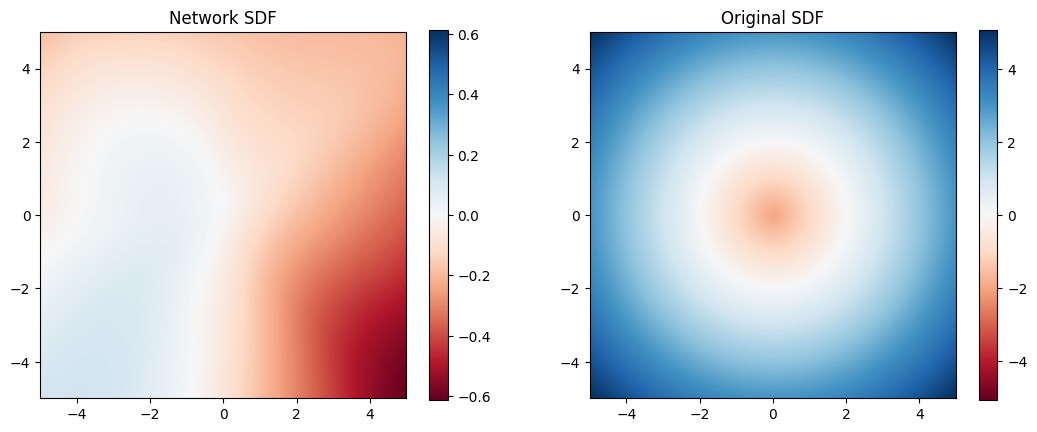

In [ ]:
compare_grid(net, circle, test_points)

### **| Model Training**

- `Net` 초기화: 신경망 모델을 생성합니다.
- `optim.SGD`: 확률적 경량법(Gradient Descent) 옵티마이저를 설정합니다.
- `StepLR`: 학습률 스케줄러를 설정하여 학습률을 점진적으로 감소시킵니다.
- `compare_grid`: 일정 에폭마다 학습된 모델의 성능을 테스트 데이터로 평가합니다.

Epoch:1999, Loss: 0.06269460171461105: 100%|██████████| 2000/2000 [01:20<00:00, 24.71it/s]


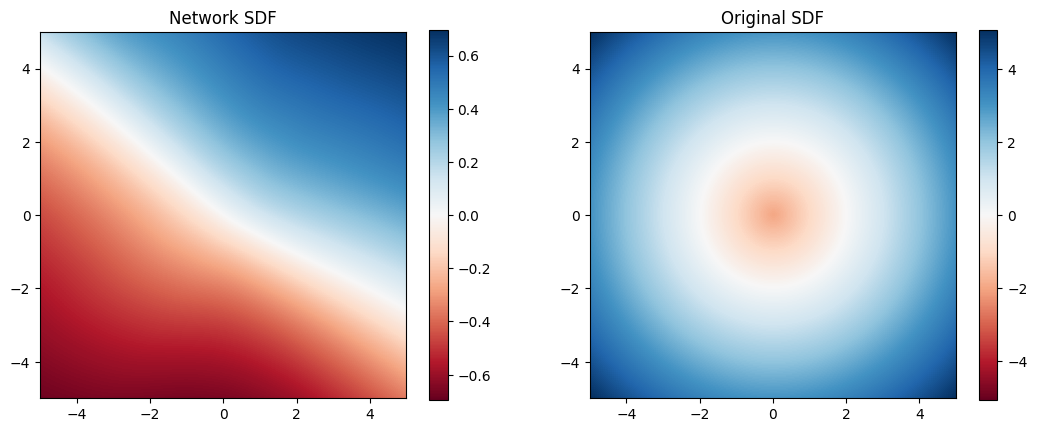

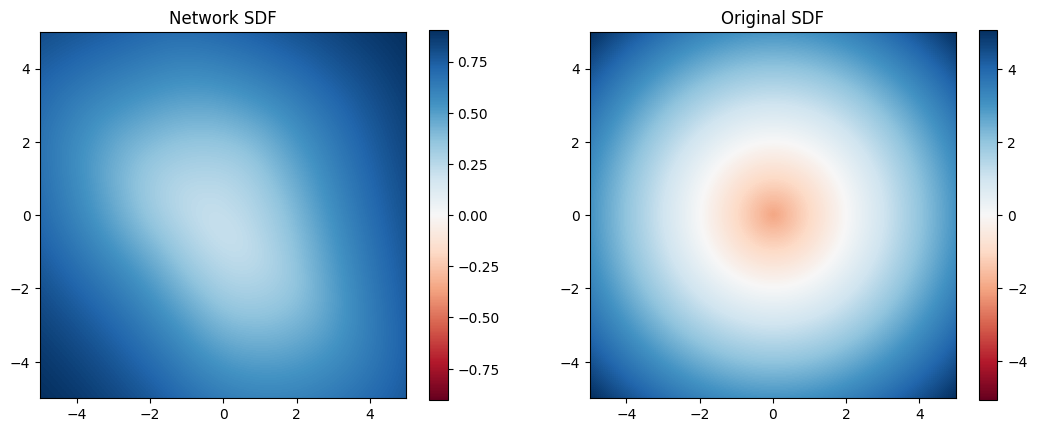

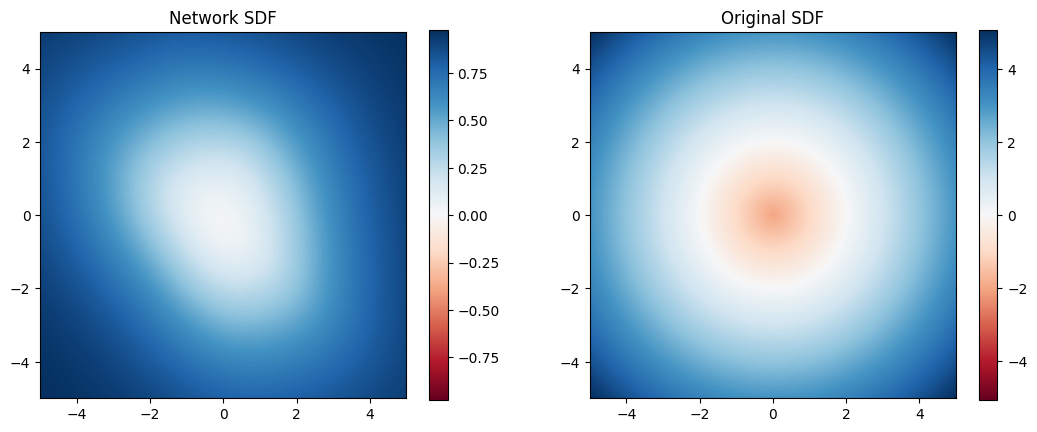

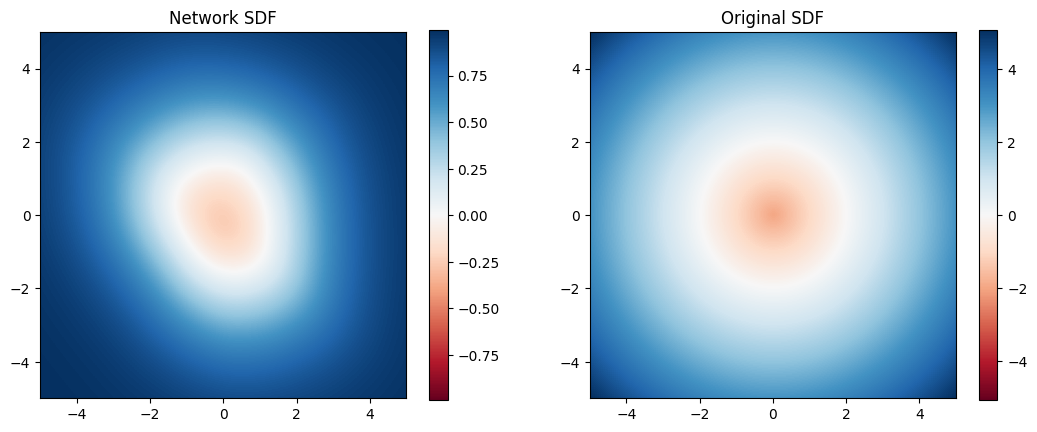

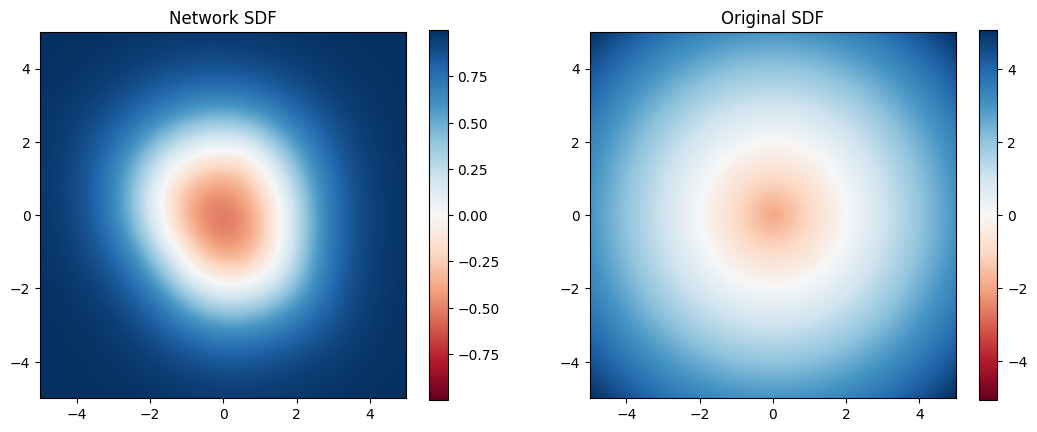

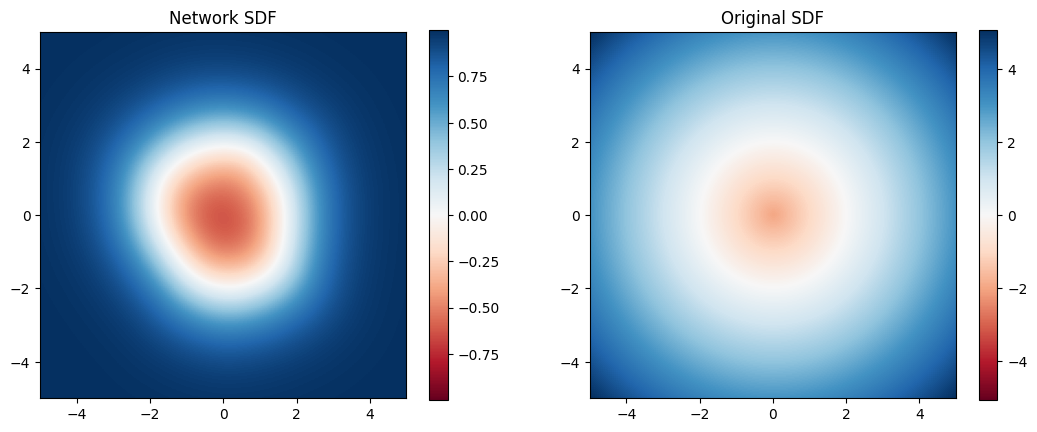

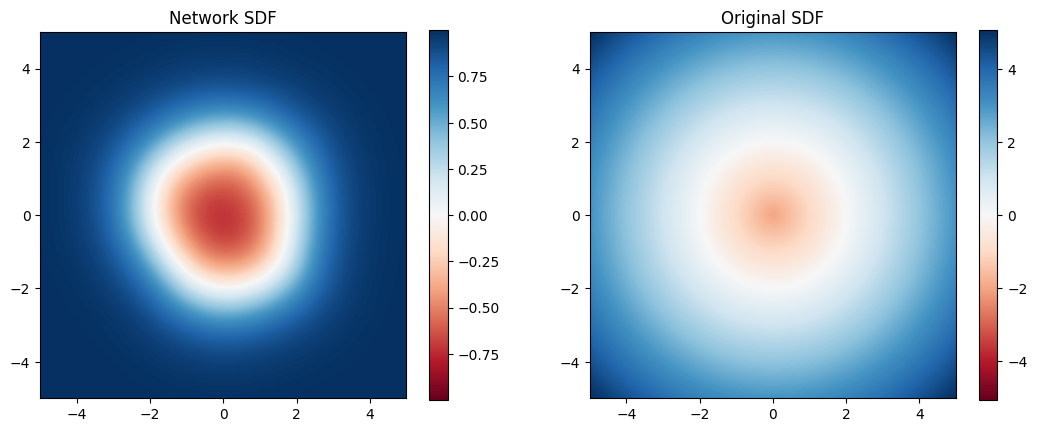

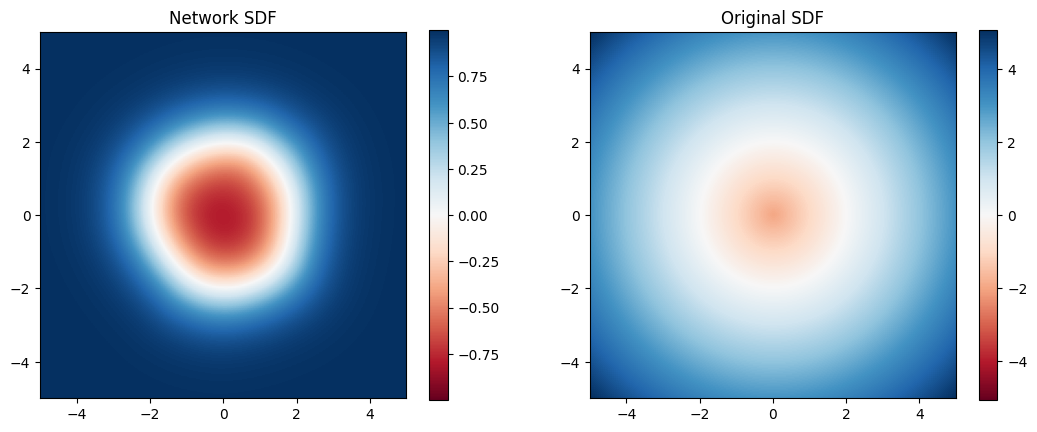

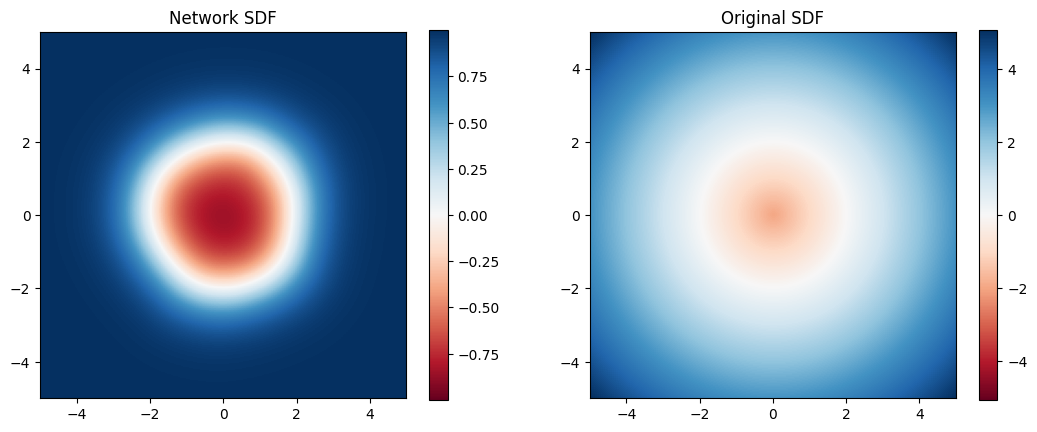

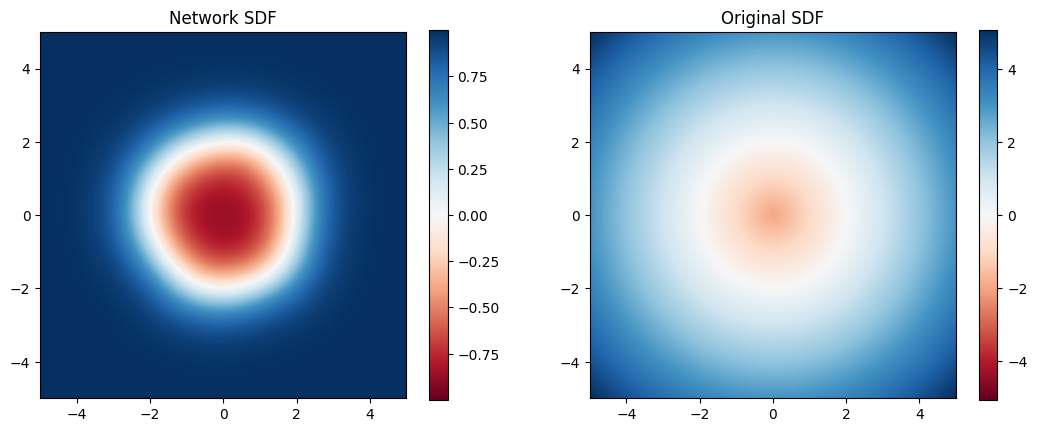

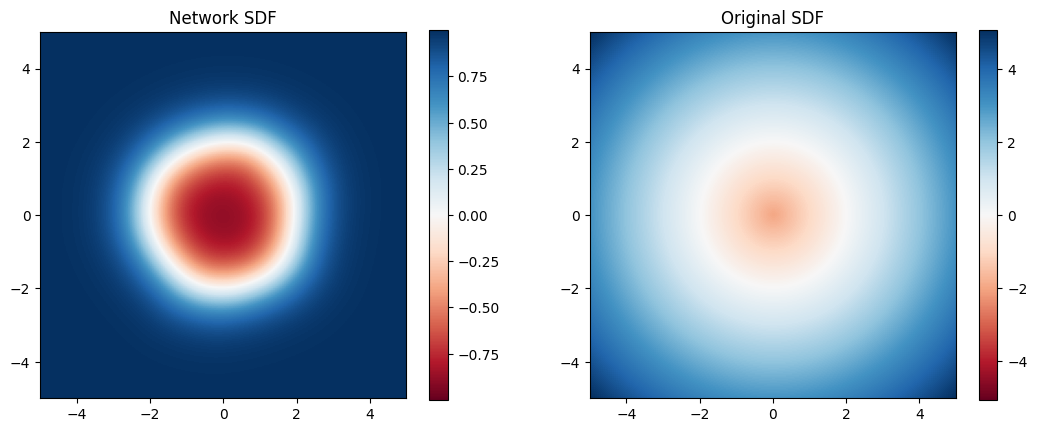

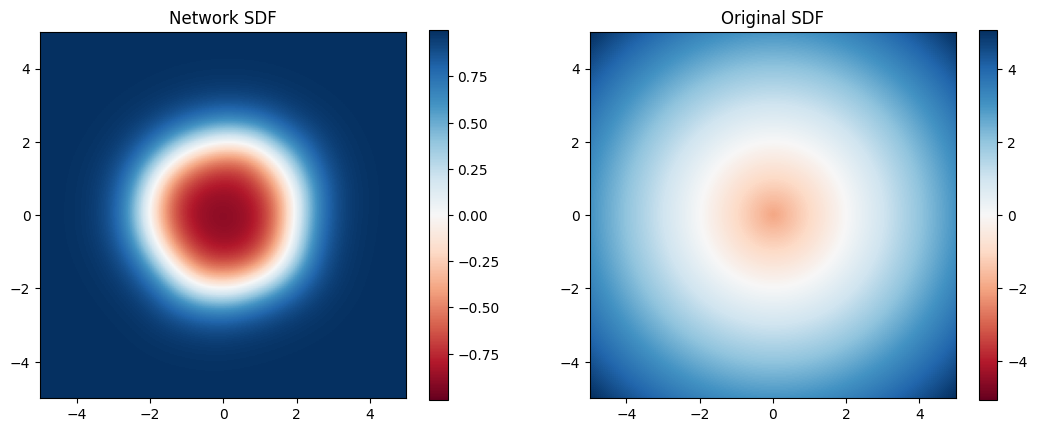

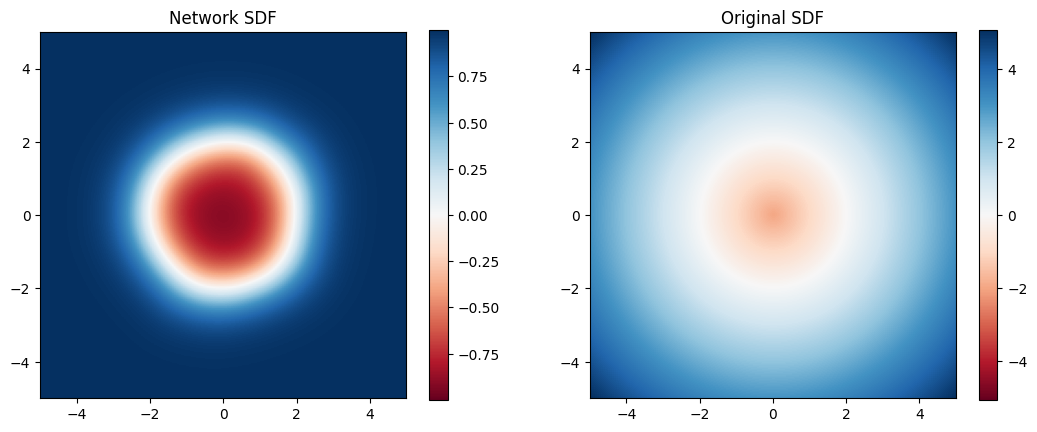

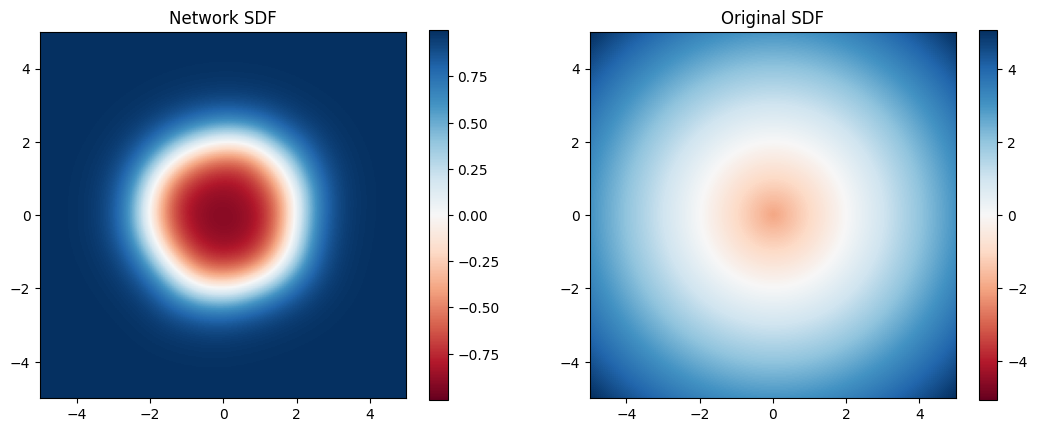

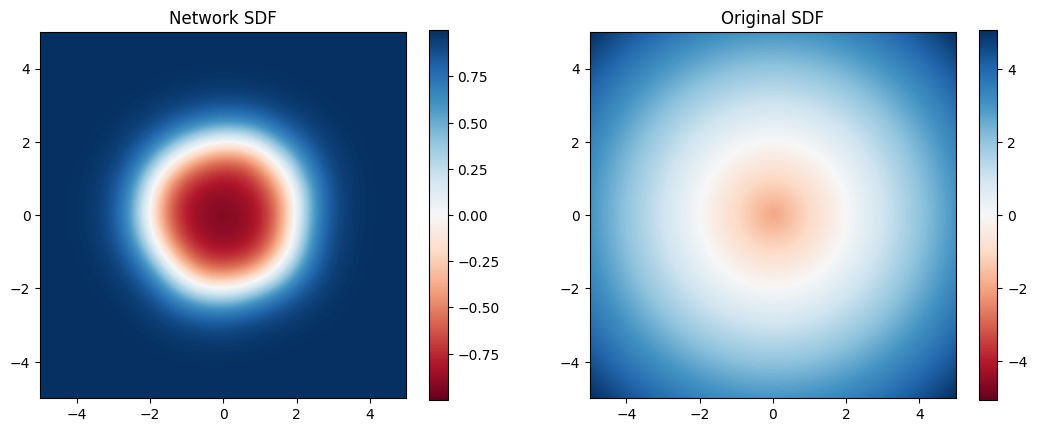

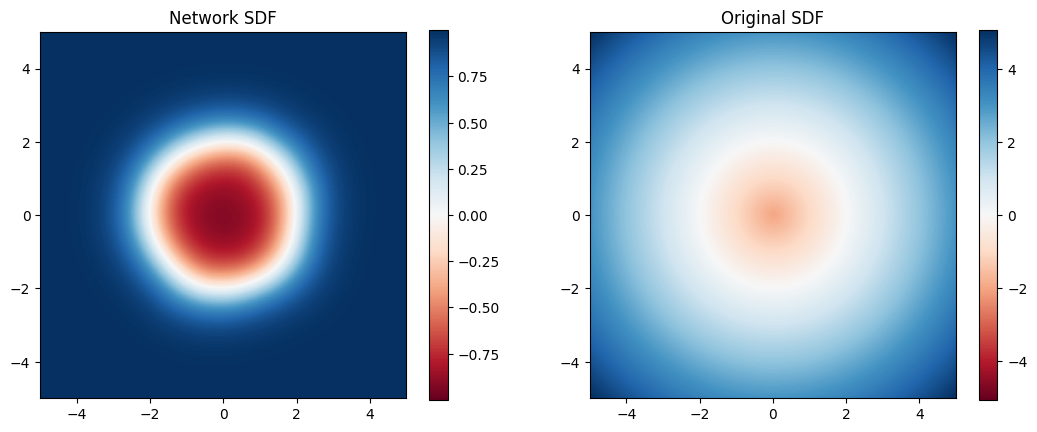

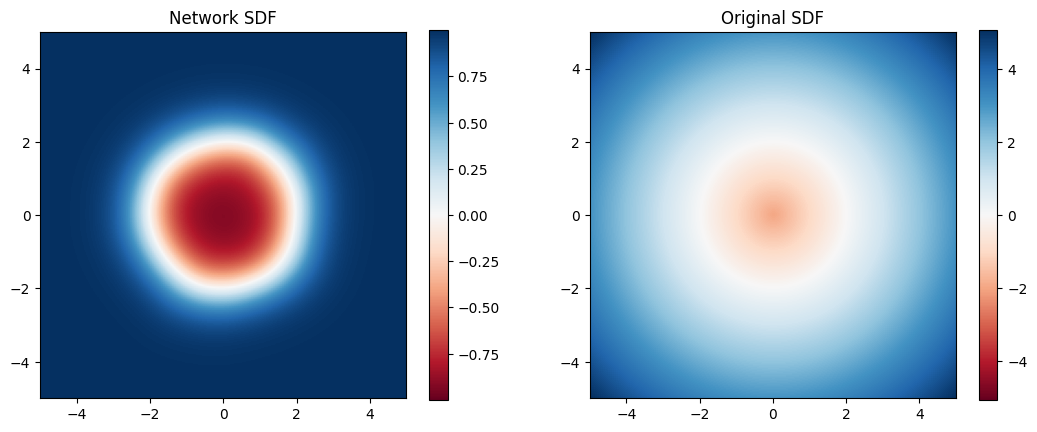

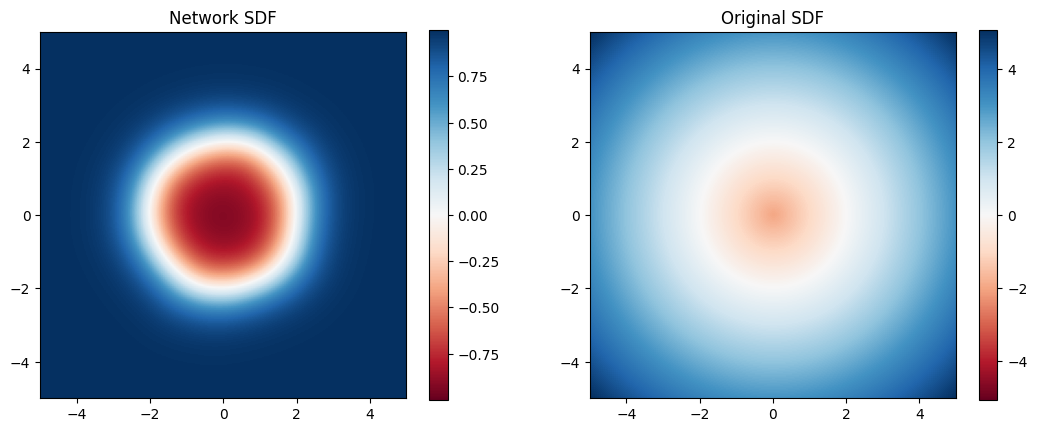

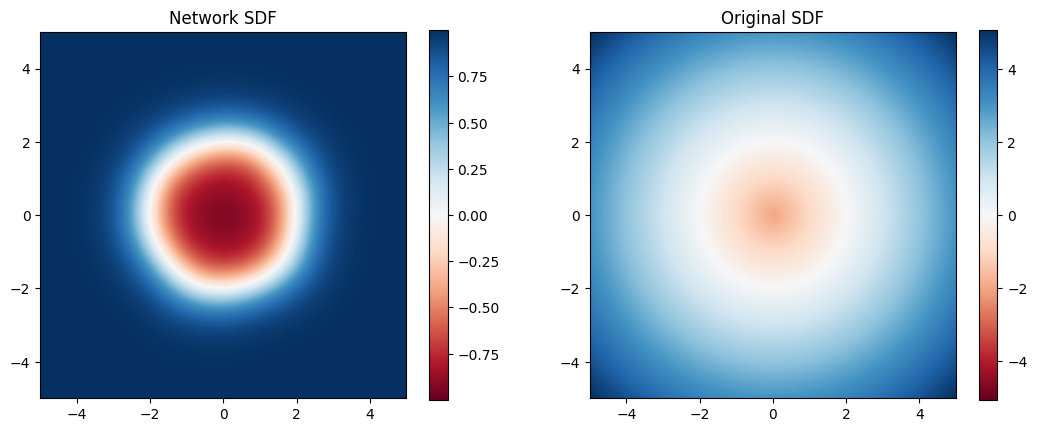

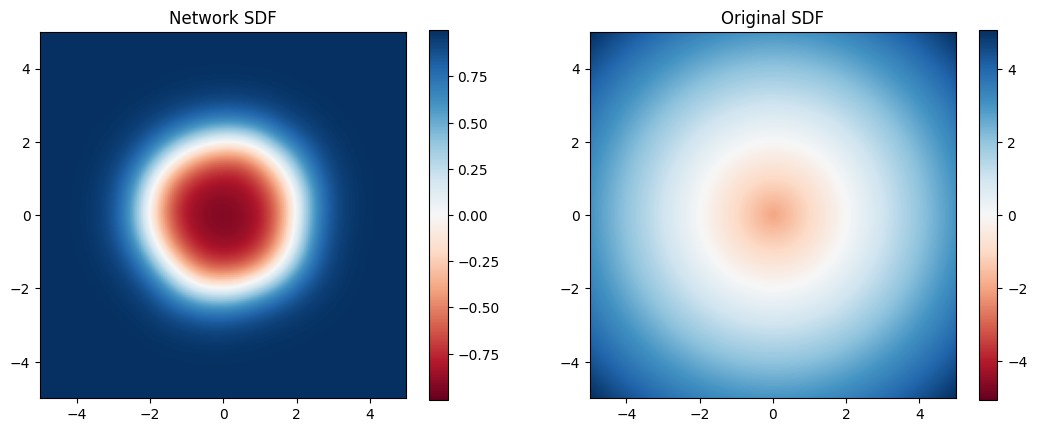

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


net = Net()
epochs = 2000
delta = 10
opt = optim.SGD(net.parameters(), lr=0.005)
scheduler = StepLR(opt, step_size=400, gamma=0.5)

pbar = tqdm(range(epochs))
loss_list = []
for epoch in pbar:
    net.train()
    total_loss = 0
    for points, sdfs in train_loader:
        pred = net(points)
        pred = pred.squeeze()
        loss = F.l1_loss(pred, sdfs)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
    loss_list.append(total_loss.item())
    pbar.set_description("Epoch:{}, Loss: {}".format(epoch, total_loss.item()))

    if (epoch % 100 == 0):
        compare_grid(net, circle, test_points)
    scheduler.step()

### **| Loss Visualization**

학습 과정을 시각화하여 손실의 변화를 확인합니다:



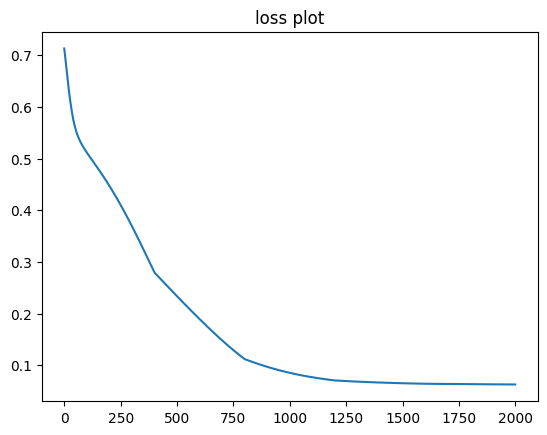

In [ ]:
plt.title("loss plot");
plt.plot(loss_list);